In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from datetime import timedelta
import requests

%matplotlib inline

import sqlite3
conn = sqlite3.connect("Resources/hawaii.sqlite")
cur = conn.cursor()


In [5]:
#Look at Tables and Columns
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cur.fetchall()
for t in tables:
    print(t)

cur.execute("SELECT sql FROM sqlite_master WHERE name='measurement'")
measureSchema = cur.fetchall()
for m in measureSchema:
    print(m)
    
cur.execute("SELECT sql FROM sqlite_master WHERE name='station'")
stationSchema = cur.fetchall()
for s in stationSchema:
    print(s)

('measurement',)
('station',)
('CREATE TABLE measurement (\n\tid INTEGER NOT NULL, \n\tstation TEXT, \n\tdate TEXT, \n\tprcp FLOAT, \n\ttobs FLOAT, \n\tPRIMARY KEY (id)\n)',)
('CREATE TABLE station (\n\tid INTEGER NOT NULL, \n\tstation TEXT, \n\tname TEXT, \n\tlatitude FLOAT, \n\tlongitude FLOAT, \n\televation FLOAT, \n\tPRIMARY KEY (id)\n)',)


In [3]:
prcp_df = pd.read_sql_query("SELECT date, prcp FROM measurement Where date Between '2016-08-23' and '2017-08-23'Order by date ASC", conn)
#prcp_df['date']=pd.to_datetime(prcp_df['date'])
#prcp_df['date']=prcp_df['date'].dt.date
prcp_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


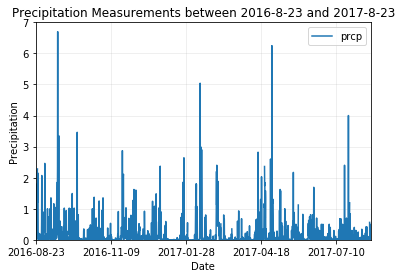

In [39]:
labels = [prcp_df.iloc[0]["date"],prcp_df.iloc[500]["date"],prcp_df.iloc[1000]["date"],prcp_df.iloc[1500]["date"],prcp_df.iloc[2000]["date"]]
#need to create array for xtick labels 
prcp_df.plot()
plt.xticks([0,500,1000,1500,2000],labels)
plt.ylim(0,7)
plt.xlim(-0.5,2230)
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.grid(alpha = 0.25)
plt.title("Precipitation Measurements between 2016-8-23 and 2017-8-23")
plt.savefig("templates\Prcp_2016823_2017823.jpg")

In [26]:
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [4]:
cur.execute('SELECT Count(*) from Station')
stations = cur.fetchall()
for s in stations:
    print("Total stations = ", s)

Total stations =  (9,)


In [5]:
cur.execute('SELECT station, count(tobs) FROM measurement GROUP BY station Order by count(tobs) DESC')
rows = cur.fetchall()
print("List of Stations")
for r in rows:
    print(r)


List of Stations
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [6]:
#Min/Max/Average from Most Active Station (USC00519281)

cur.execute('SELECT min(tobs), max(tobs), avg(tobs) FROM measurement where station = "USC00519281"')
tempData = cur.fetchall()
print("Min/Max/Average Temperature for Station USC00519281 (all time)")
for t in tempData:
    print(t)

Min/Max/Average Temperature for Station USC00519281 (all time)
(54.0, 85.0, 71.66378066378067)


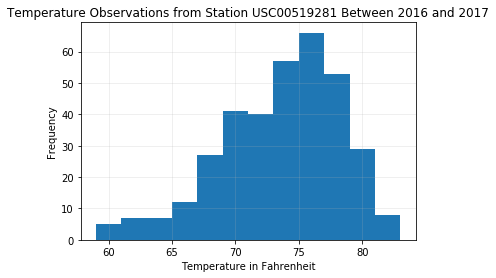

In [40]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_df = pd.read_sql_query("SELECT tobs FROM measurement Where measurement.date Between '2016-08-23' and '2017-08-23'and station = 'USC00519281'", conn)

plt.hist(tobs_df['tobs'], bins=12)
plt.title("Temperature Observations from Station USC00519281 Between 2016 and 2017")
plt.xlabel("Temperature in Fahrenheit")
plt.ylabel("Frequency")
plt.grid(alpha = 0.25)

plt.savefig("templates\Tobs_2016823_2017823.jpg")
plt.show()


In [32]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.

    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """ 
    cur.execute('SELECT min(tobs),max(tobs),avg(tobs) FROM measurement WHERE date BETWEEN ? AND ?', [start_date,end_date])
    rows = cur.fetchall()
    for r in rows:
        results = r
    
    return results

    #return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
     #   filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example

print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 74.0, 69.57142857142857)


In [33]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacations_temps = calc_temps('2017-06-15', '2017-06-30')
print(vacations_temps)

(71.0, 82.0, 77.01980198019803)


Text(0,0.5,'Temperature')

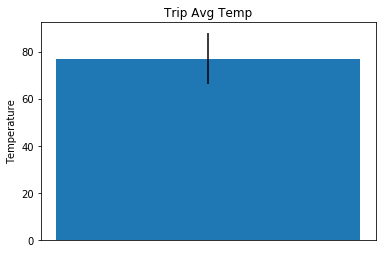

In [38]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar(x = 1, height = vacations_temps[2], yerr = (vacations_temps[1] -vacations_temps[0]) )
plt.xticks([])
plt.title("Trip Avg Temp")
plt.ylabel("Temperature")

In [56]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

print("Total Rainfall Per Station For 2017-06-15 - 2017-06-30")
print("Station, Name, Lat, Long, Elevation, Total Prcp")
cur.execute("SELECT s.station, s.name, s.latitude, s.longitude, s.elevation, sum(m.prcp) FROM measurement m JOIN station s ON s.station = m.station WHERE m.date BETWEEN '2017-06-15' AND '2017-06-30' GROUP BY s.station ORDER BY sum(m.prcp) DESC")
rainfall = cur.fetchall()
for r in rainfall:
    print(r)


Total Rainfall Per Station For 2017-06-15 - 2017-06-30
Station, Name, Lat, Long, Elevation, Total Prcp
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 5.479999999999999)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.83)
('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.1900000000000004)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.88)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.21000000000000002)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.13)
('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.12)


In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    cur.execute('SELECT min(tobs),max(tobs),avg(tobs) FROM measurement WHERE date like ?',('%'+date+"%",))
    rows = cur.fetchall()
    for r in rows:
        results = r
    
    return results

    #sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    #return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")


(62.0, 77.0, 69.15384615384616)

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start = '2017-06-15'
end = '2017-06-30'
s_date = datetime.strptime(start, "%Y-%m-%d")
e_date = datetime.strptime(end, "%Y-%m-%d")
days = [s_date]

# Use the start and end date to create a range of dates
vaca_len = e_date - s_date
date_range = [s_date]
for i in range(vaca_len.days):
    date_range.append(datetime.strftime(s_date + timedelta(days=i)))
    
print(date_range)    
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

2017-06-15 00:00:00
[datetime.datetime(2017, 6, 15, 0, 0), datetime.date(2017, 6, 15), datetime.date(2017, 6, 16), datetime.date(2017, 6, 17), datetime.date(2017, 6, 18), datetime.date(2017, 6, 19), datetime.date(2017, 6, 20), datetime.date(2017, 6, 21), datetime.date(2017, 6, 22), datetime.date(2017, 6, 23), datetime.date(2017, 6, 24), datetime.date(2017, 6, 25), datetime.date(2017, 6, 26), datetime.date(2017, 6, 27), datetime.date(2017, 6, 28), datetime.date(2017, 6, 29)]


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


<class 'str'>
